In [1]:
%matplotlib inline

In [3]:
import nltk 
import networkx as nx
import numpy as np
import pandas as pd
from nltk.corpus import wordnet as wn
from tqdm import tqdm
import scipy
from scipy import sparse as sp
from scipy.sparse.linalg import eigs
from matplotlib import pyplot as plt
from collections import defaultdict
from sklearn.cluster import KMeans

from helpers import (
    signed_layout, draw_nodes, draw_edges, flatten, signed_laplacian, 
    normalized_laplacian, signed_normalized_laplacian, conductance_by_sweeping,
    dict2array, signed_group_conductance,
    get_borderless_fig,
    labels2groups
)
from sweeping import sweeping_scores_using_ppr
from spectral import signed_spectral_clustering
# from algorithms.pagerank import pr_score
from motif_adjacency import motif_eef

In [4]:
raw_g = nx.read_gpickle('graphs/thesaurus.pkl')

In [5]:
node2word = {n: w for n, w in enumerate(raw_g.nodes())}
word2node = {w: n for n, w in enumerate(raw_g.nodes())}

In [6]:
g = nx.relabel_nodes(raw_g, mapping=word2node)

In [7]:
A = nx.adj_matrix(g, weight='sign')
W = motif_eef(A)
g_motif = nx.from_scipy_sparse_matrix(W)

In [10]:
query_word = 'happy'
query = word2node[query_word]
alpha = 0.5

best position 3486
community [13956  4553   419 ... 15326 14827 10106]


/home/cloud-user/code/signed/sweeping.py:17: RuntimeWarning: invalid value encountered in true_divide
  node_scores = z_vect / deg
/home/cloud-user/code/signed/helpers.py:426: RuntimeWarning: invalid value encountered in true_divide
  scores = num_cut / vols


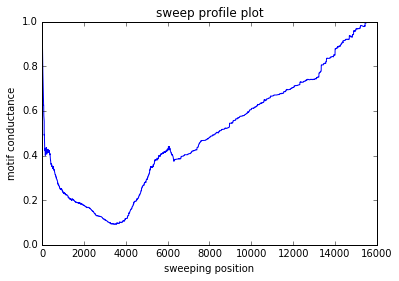

In [11]:
order, sweep_positions, sweep_scores = sweeping_scores_using_ppr(
    g_motif, query, alpha, A=W
)

fig, ax = plt.subplots(1, 1)
ax.plot(sweep_positions, sweep_scores)
ax.set_title('sweep profile plot')
ax.set_xlabel('sweeping position')
ax.set_ylabel('motif conductance')

# get the best community
best_pos = np.argmin(sweep_scores)
comm = order[:best_pos+1]
print('best position', best_pos+1)
print('community', comm)

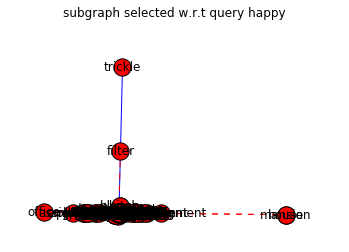

In [15]:
subg = g.subgraph(comm)
mapping = {n: i for i, n in enumerate(comm)}
mapping_reverse = {v: k for k, v in mapping.items()}

subg = nx.relabel_nodes(subg, mapping=mapping)

pos = signed_layout(subg)

fig, ax = get_borderless_fig()    
nx.draw_networkx_nodes(subg, pos, node_size=300)
nx.draw_networkx_labels(subg, pos, labels={mapping[n]: node2word[n] for n in comm})
draw_edges(subg, pos)
ax.set_title('subgraph selected w.r.t query {}'.format(query_word))
# fig.savefig(fig_dir + '/subgraph-selected.' + FIG_FORMAT)

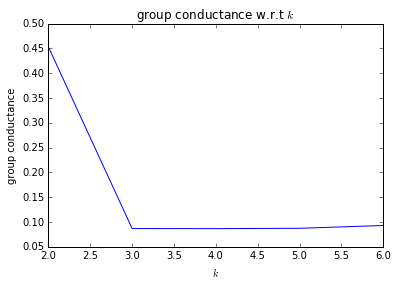

In [16]:
ks = [2, 3, 4, 5, 6]
avg_phi_list = []
for k in ks:
    labels = signed_spectral_clustering(subg, k, normalize=True)
    groups = labels2groups(labels)
    avg_phi_list.append(signed_group_conductance(subg, groups.values()))

best_k = ks[np.argmin(avg_phi_list)]    

fig, ax = plt.subplots(1, 1)
ax.plot(ks, avg_phi_list)
ax.set_title('group conductance w.r.t $k$')
ax.set_xlabel('$k$')
ax.set_ylabel('group conductance')


In [18]:
labels = signed_spectral_clustering(subg, k, normalize=True)

groups = {
    i: [node2word[mapping_reverse[n]] for n in grp]
    for i, grp in labels2groups(labels).items()
}

for k, grp in groups.items():
    print('group {} ({}) {}'.format(k, len(grp), ' '.join(grp[:10])))

group 0 (1585) happy serendipitous pleased contented glad lucky triumphant celebratory unrepentant joyful
group 1 (15) flashing glow glisten twinkle brightness lightness afterglow luster glitter shimmer
group 2 (313) melancholy upset ennui bleakness exasperated pessimism hopelessness storm pity snowstorm
group 3 (1563) hapless incensed teary touching fractious beat down irate untoward apologetic impatient
group 4 (10) business office duty employment work job project function profession assignment
